In [1]:
import sys
import re
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize

import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

sys.path.insert(0, "../../")
from common import data_utils as data_utils
from common import plot_utils as plot

In [2]:
folder = ""

In [3]:
# URI as text
uri_encoding = "utf-8"
out_uri_encoding = "utf-8"
output_file_normal = "uri_all_normal_wordlevel.txt"
output_file_abnormal = "uri_all_abnormal_wordlevel.txt"

In [4]:
def read(file):
    with open(str(folder + file), 'r', encoding=uri_encoding, errors="backslashreplace") as f:
        samples = list(f)
        return samples

In [5]:
good_uris = read("uri_all_normal.txt")
len(good_uris)

1401537

In [6]:
bad_uris = read("uri_all_abnormal.txt")
len(bad_uris)

87904

In [7]:
all_uris = []
all_uris.extend(good_uris)
all_uris.extend(bad_uris)
len(all_uris)

1489441

In [8]:
y = np.concatenate((np.zeros(len(good_uris)), np.ones(len(bad_uris))))

In [9]:
x_train, x_test, y_train, y_test = train_test_split(all_uris, y, test_size=0.20, random_state=47)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=47)

In [11]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
class_weights

array([0.53144074, 8.45146733])

In [12]:
expert_keys = ['<','>','../','<>','’','-','*/',';','+','=','(',':','||','*','“','“','–>','&','#include','select',
            'alert','exec','union','order','winnt','commit','alter','from','where','count','passwd','script','table',
             'shell','into','document.cookie','etc/passwd','password','bash_history','path/child','onmouseover','User-Agent:',
             'javascript:','between','objectclass','Accept:','upper','insert','and','href','mail=',
             ')','<!–','/','/*','|','$','0%','cn=','cmd','or','%0a','url=','.exe','.dll','cgi-bin']

# Left Part

In [13]:
wnl = WordNetLemmatizer()
def tokenizer_custom_part_left(uri):
    uri = str(uri)
    uri = uri.lower()
    uri = re.sub(r"[\d+]|\n", "",  uri)
    uri = re.split('(\/|\?|=|&|%|\+|-|\.|,|_|~|\*|<|>| |\:)', uri)
    uri = [ wnl.lemmatize(word) for word in uri if word not in expert_keys]
    return uri

In [14]:
def compute_bag_part_left():
    print("Calculating")
    vectorizer = CountVectorizer(max_features=500, tokenizer=tokenizer_custom_part_left)
    bag = vectorizer.fit_transform(x_train)
    joblib.dump(vectorizer, "vectorizer_count_part_left.joblib")
    return vectorizer, bag
    

In [15]:
force = False
try:
    if force:
        vectorizer_left, bag_left = compute_bag_part_left()
    else:
        print("Loading")
        vectorizer_left = joblib.load("vectorizer_count_part_left.joblib")
        bag_left = vectorizer_left.transform(x_train)
except:
    vectorizer_left, bag_left = compute_bag_part_left()

Loading


In [16]:
x_train_part_left = bag_left.toarray()
x_train_part_left.shape

(953241, 500)

In [17]:
x_val_part_left = vectorizer_left.transform(x_val).toarray()

In [18]:
x_test_part_left = vectorizer_left.transform(x_test).toarray()

# Right Part

In [19]:
def tokenizer_custom_part_right(uri):
    uri = str(uri)
    uri = uri.lower()
    uri = re.sub(r"[\d+]|\n", "",  uri)
    uri = re.split('(\/|\?|=|&|%|\+|-|\.|,|_|~|\*|<|>| |\:)', uri)
    uri = [word for word in uri if word in expert_keys]
    return uri

In [20]:
def compute_bag_part_right():
    print("Calculating")
    vectorizer = CountVectorizer(max_features=500, tokenizer=tokenizer_custom_part_right)
    bag = vectorizer.fit_transform(x_train)
    joblib.dump(vectorizer, "vectorizer_count_part_right.joblib")
    return vectorizer, bag
    

In [21]:
force = False
try:
    if force:
        vectorizer_right, bag_right = compute_bag_part_right()
    else:
        print("Loading")
        vectorizer_right = joblib.load("vectorizer_count_part_right.joblib")
        bag_right = vectorizer.transform(x_train)
except:
    vectorizer_right, bag_right = compute_bag_part_right()

Loading
Calculating


In [22]:
x_train_part_right = bag_right.toarray()
x_train_part_right.shape

(953241, 43)

In [23]:
x_val_part_right = vectorizer_right.transform(x_val).toarray()

In [24]:
x_test_part_right = vectorizer_right.transform(x_test).toarray()

# Laplacian privatizer

In [25]:
n_x_train_part_left = x_train_part_left
n_x_val_part_left = x_val_part_left
n_x_test_part_left = x_test_part_left

# DP Type


In [26]:
partial = False

In [27]:
def get_mechanism(eps):
    
    def test_randomizer(row):
        return row
    
    def laplace_randomizer(row):
        scale = 1/eps
        noise = np.random.laplace(0, scale, row.shape)
        return row + noise
    
    return laplace_randomizer
    
def privatize_matrix(data, randomizer):
    return np.apply_along_axis(randomizer, axis=1, arr=data)

In [28]:
epsilon = 0.5

In [29]:
if partial:
    print("privatizing")
    n_x_train_part_left = normalize(n_x_train_part_left, axis = 1, norm = 'l1')
    n_x_train_part_left = privatize_matrix(n_x_train_part_left, get_mechanism(epsilon))
    
    n_x_val_part_left = normalize(n_x_val_part_left, axis = 1, norm = 'l1')
    n_x_val_part_left = privatize_matrix(n_x_val_part_left, get_mechanism(epsilon))
    
    n_x_test_part_left = normalize(n_x_test_part_left, axis = 1, norm = 'l1')

# Merge

In [30]:
f_x_train = np.hstack((n_x_train_part_left, x_train_part_right))
f_x_train.shape

(953241, 543)

In [31]:
f_x_val = np.hstack((n_x_val_part_left, x_val_part_right))
f_x_test = np.hstack((n_x_test_part_left, x_test_part_right))

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(f_x_train.shape[1],), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               278528    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [34]:
optim = tf.optimizers.Adam(lr=0.00001)
model.compile(optimizer=optim, loss='binary_crossentropy')

In [35]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [37]:
history = model.fit(f_x_train, y_train, epochs=50, batch_size=128, validation_data=(f_x_val, y_val), class_weight=class_weights, callbacks=[callback])

Epoch 1/50
7448/7448 [==============================] - 34s 5ms/step - loss: 0.3401 - val_loss: 0.1957
Epoch 2/50
7448/7448 [==============================] - 35s 5ms/step - loss: 0.2104 - val_loss: 0.1533
Epoch 3/50
7448/7448 [==============================] - 37s 5ms/step - loss: 0.1750 - val_loss: 0.1419
Epoch 4/50
7448/7448 [==============================] - 37s 5ms/step - loss: 0.1541 - val_loss: 0.1286
Epoch 5/50
7448/7448 [==============================] - 37s 5ms/step - loss: 0.1425 - val_loss: 0.1220
Epoch 6/50
7448/7448 [==============================] - 37s 5ms/step - loss: 0.1342 - val_loss: 0.1157
Epoch 7/50
7448/7448 [==============================] - 37s 5ms/step - loss: 0.1290 - val_loss: 0.1055
Epoch 8/50
7448/7448 [==============================] - 35s 5ms/step - loss: 0.1245 - val_loss: 0.1014
Epoch 9/50
7448/7448 [==============================] - 34s 5ms/step - loss: 0.1214 - val_loss: 0.1009
Epoch 10/50
7448/7448 [==============================] - 35s 5ms/step - l

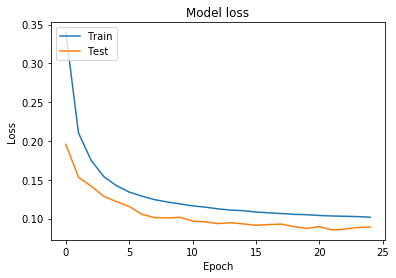

In [38]:
plot.plot(history)

In [39]:
val_pred = model.predict(f_x_val)

In [40]:
fpr, tpr, thresholds = roc_curve(y_val, val_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.49884206

In [41]:
test_pred = model.predict(f_x_test)

In [42]:
y_hat = test_pred > optimal_threshold

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print(tn, fp, fn, tp)

269951 10409 479 17050


In [44]:
tpr = tp / (tp + fn)
tpr


0.9726738547549775

In [45]:
tnr = tn / (tn + fp)
tnr

0.9628727350549294